In [1]:
import matplotlib.pyplot as plt
from matplotlib  import rc
import pandas as pd
import geopandas as gpd
import numpy as np
import os

In [2]:
bank_tract = pd.read_csv('../input_data_clean/bank_tract_clean_WITH_CENSUS.csv')

#denial_rate, credit_spread, np.log(# loans), np.log($ loans), avg LTV 
bank_tract ["white_rate"]        = (bank_tract ["WhitePop"]) / bank_tract ["Tot.Pop"] * 100
bank_tract ['majority-minority'] = bank_tract ["white_rate"] < 50
bank_tract ['below_p10_income']  = bank_tract ["Med.HousehIncome"] < bank_tract["Med.HousehIncome"].quantile(0.1)
bank_tract ['high_hispanic']     = (bank_tract ['HispanicLatinoPop'] / bank_tract['Tot.Pop']) > 0.25
bank_tract ['high_black']        = (bank_tract ['BlackPop'] / bank_tract['Tot.Pop']) > 0.25
bank_tract ['high_asian']        = (bank_tract ['AsianPop'] / bank_tract['Tot.Pop']) > 0.25
bank_tract ['high_white']        = (bank_tract ['WhitePop'] / bank_tract['Tot.Pop']) > 0.25

bank_tract ['log(numloans)'] = np.log(bank_tract['num_approved_loans'])
bank_tract ['log(dol_loans)'] = np.log(bank_tract['avg_approved_loan_size'])


In [3]:
# Get the Arizona tract shapefile and convert to UTM Zone 17N coordinate system
shape_az = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_04_tract.zip").to_crs(epsg=32617)
shape_ca = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_06_tract.zip").to_crs(epsg=32617)
shape_all = pd.concat([shape_az, shape_ca], ignore_index=True)
shape_all['census_tract'] = shape_all['GEOID'].astype(np.int64)

In [4]:
# merge the shape file with bank_tract
bank_tract_with_shape = shape_all.merge(bank_tract, how = 'right', on = ['census_tract'],
                                        indicator = True, validate= '1:m') 

In [5]:
# set up map zooms
cities     = ['phx', 'tcs', 'sf', 'la']
phx_zoom   = {'x': [-2.5e6,-2.35e6],     'y' : [4.1e6,4.25e6],    'city':'phx'}
la_zoom    = {'x': [-3.06e6, -2.9e6], 'y': [4.35e6, 4.5e6], 'city':'LA'}
sf_zoom    = {'x': [-3.25e6, -3.15e6], 'y': [4.975e6, 5.12e6], 'city':'LA'}
tcs_zoom   = {'x': [-2.4e6, -2.35e6],   'y': [3.95e6, 4.025e6],   'city':'tuscon'}
citieszoom = [phx_zoom, tcs_zoom, sf_zoom, la_zoom]

In [6]:
# 
listofshading   = ['denial_rate', 'mean_approved_rate_spread', 'log(numloans)', 'log(dol_loans)', 'mean_LTV']
listofredlining = ['majority-minority', 'below_p10_income', 'high_hispanic', 'high_black', 'high_asian', 'high_white']

In [30]:
def red_line_map(df,shading_var:str,redline_var:str,optional_title= None,option_zoom_params=None):
    fig, ax = plt.subplots(1, 1, figsize = (20, 10))

    # Plot data
    # Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
    df.plot(column = shading_var,
            ax = ax,
            cmap = "RdYlGn",
            legend = True)

    # add the the majority minority tract lines in red
    query = f'`{redline_var}`'
    df.query(query).boundary.plot(color='red',ax=ax, linewidth=2)

    # add the other tract lines in grey
    query = f'`{redline_var}` == False'    
    df.query(query).boundary.plot(color='gainsboro',ax=ax, linewidth=.2)

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    if optional_title:
        plt.title(f'{optional_title}', fontdict = {'fontsize': 15})
        
    # optionally, zoom in
    if option_zoom_params:
        ax.set_xlim(option_zoom_params['x'])
        ax.set_ylim(option_zoom_params['y'])
        
    return fig, ax

## Ideas to better graphs

- log(1+numloans)
- diff between BOW and Competitors
- less granular 
- a new shading variable that is "% of # of loans this bank makes in this tract" should be defined in every tract (0 if missing!)
- a new shading variable that is "% of $ of loans this bank makes in this tract" should be defined in every tract (0 if missing!)

Create a mapping plot that depicts the difference in denial rate by minority group between BMO and All Other Banks & between BOTW and All Other Banks


(<Figure size 2000x1000 with 2 Axes>, <AxesSubplot:>)

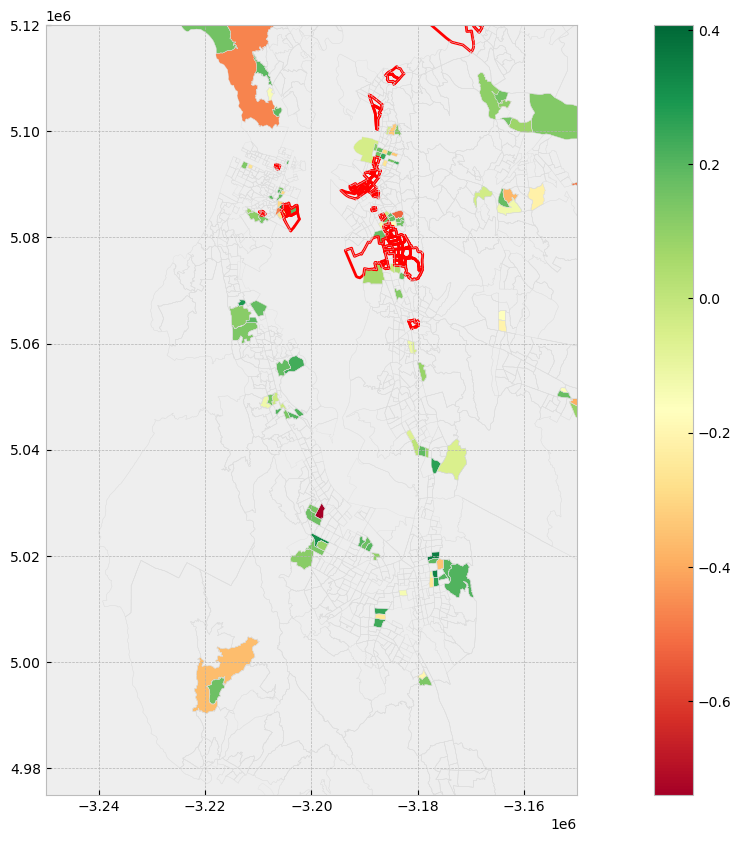

In [31]:
import seaborn as sns

# Calculate the denial rate difference for each tract
# denials_df = bank_tract_with_shape.query('') # this data only has bank of the west and all other banks (BMO is in that) 

denials_df = bank_tract_with_shape.pivot_table(index = 'tract', columns = 'which_bank', values = 'denial_rate')
bank_tract_with_shape['denial_rate_difference'] = denials_df['Bank of West'] - denials_df['All Other Banks']

# bank_tract_with_shape['which_bank'].info()
# denials_df['which_bank'].info() #bow 4500 #aob 9337
# bank_tract['denial_difference'].info()

# .query(drop BMO)
# .pivot_table(index = tract, col = Bank, value= Denial)

red_line_map(bank_tract_with_shape, 'denial_rate_difference', 'high_black', False ,sf_zoom)


In [ ]:
# Create the scatter plot
sns.set_style("white")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.2)
g = sns.lmplot(data=bank_tract, x='high_black', y='denial_difference', hue='which_bank', scatter_kws={"s": 50}, height=7)

# Customize the plot
g.set_axis_labels("% Black Population in Tract", "Denial Rate Difference\n(BOTW or BMO - AOB)")
g.ax.set_title("Denial Rate Differences by Minority Group\nBetween BMO/BOTW and All Other Banks")

In [ ]:
aob = bank_tract_with_shape.query('which_bank == "All Other Banks"')
bow = bank_tract_with_shape.query('which_bank == "Bank of West"')
bank_tract['denial_rate']
bank_tract['high_black']
bank_tract['denial_difference'] = bow['denial_rate'] - aob['denial_rate']

# Call the function with the zoom parameters
red_line_map(bank_tract, 'denial_difference', 'high_black', option_zoom_params= sf_zoom)

In [ ]:
%%capture

for bank in ['All Other Banks','Bank of West']:    
    this_bank = bank_tract_with_shape.query('which_bank == @bank')
    for city in citieszoom: 
        for shade in listofshading:
            for redline in listofredlining:
                
                # where to put this beaut
                # pic_fname = f'''../images/{city['city']}/{bank}/SHADE {shade}/{redline}.png'''
                
                # make sure it has a home
                # os.makedirs(os.path.dirname(pic_fname),
                                            # exist_ok=True)
                
                # make and save!
                fig = red_line_map(this_bank,
                                   shade, redline, f"""{bank} ||| {city['city']} ||| {shade} ||| {redline}""", city)
                                
                # plt.savefig(pic_fname)
                # plt.close(fig)
                plt.show()
                clear()
